In [1]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm 
import os
from datasets import load_dataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ds = load_dataset("clip-benchmark/wds_mscoco_captions")

Loading dataset shards:   0%|          | 0/27 [00:00<?, ?it/s]

In [2]:
vizwiz = load_dataset("Multimodal-Fatima/VizWiz_train")

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
train = ds['train']

In [4]:
train_img_capt = train#.select(range(10000))

In [32]:
test_img = train_img_capt[6000]

In [33]:
test_img

{'jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x375>,
 'txt': 'A commercial plane on a runway with snow on the ground.\nA large airplane sitting on a landing strip.\nAn airplane sitting on a runway in the snow.\nThe airplane is stopped on a runway surrounded by snow.\na plane sitting in the middle of the runway'}

In [7]:
train_img_capt

Dataset({
    features: ['__key__', '__url__', 'jpg', 'txt'],
    num_rows: 82783
})

In [8]:
train_img_capt = train_img_capt.remove_columns(['__key__','__url__'])

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
resize_transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor()  
    ])

In [37]:
def preprocess_img(data):

    """
    Preprocesses a single data instance for multimodal training.

    Parameters:
    - data (dict): A dictionary containing:
        - 'jpg': An image file in PIL.Image format.
        - 'txt': A string with the 4 captions
    Returns:
    - dict: A dictionary with preprocessed image and the captions tokenized, containing:
        - 'img': The transformed image as a tensor.
        - 'input_ids': Token IDs for the tokenized captions.
        - 'attention_mask': Attention mask for the tokenized captions.
    """
    
    img = data['jpg'].convert("RGB")
    images = resize_transform(img)
    
    sentences = data['txt']
    sentences = sentences.split('\n')  
    sentences = " [SEP] ".join(sentences) 
    #print(sentences)
    
    tokenized_text = tokenizer.encode_plus(sentences, add_special_tokens = True, padding="max_length",truncation=True,max_length = 100,return_tensors='pt')

    return {
        'img': images,
        'input_ids' : tokenized_text['input_ids'].squeeze(0),
        'attention_mask' : tokenized_text['attention_mask'].squeeze(0)
        
     }

processed_train = train_img_capt.map(preprocess_img)
pytorch_train = processed_train.with_format(type='torch', columns = ['img','input_ids','attention_mask'])


data_loader = DataLoader(pytorch_train,batch_size = 32, shuffle = True)
    

In [14]:
def preprocess_img(data):

    """
    Preprocesses a single data instance for multimodal training.

    Parameters:
    - data (dict): A dictionary containing:
        - 'jpg': An image file in PIL.Image format.
        - 'txt': A string with the captions.
    Returns:
    - dict: A dictionary with preprocessed image and only the first of the captions tokenized, containing:
        - 'img': The transformed image as a tensor.
        - 'input_ids': Token IDs for the tokenized caption.
        - 'attention_mask': Attention mask for the tokenized caption.
    """
    
    img = data['jpg'].convert("RGB")
    images = resize_transform(img)
    
    # Keep only the first sentence
    sentence = data['txt'].split('\n')[0]
    
    tokenized_text = tokenizer.encode_plus(
        sentence, 
        add_special_tokens=True, 
        padding="max_length", 
        truncation=True, 
        max_length=30, 
        return_tensors='pt'
    )

    return {
        'img': images,
        'input_ids': tokenized_text['input_ids'].squeeze(0),
        'attention_mask': tokenized_text['attention_mask'].squeeze(0)
    }

processed_train = train_img_capt.map(preprocess_img)
pytorch_train = processed_train.with_format(type='torch', columns=['img', 'input_ids', 'attention_mask'])

data_loader = DataLoader(pytorch_train, batch_size=32, shuffle=True)


In [38]:
for batch in data_loader:
    print(batch['input_ids'].shape)
    break

torch.Size([32, 100])


In [25]:
for batch in data_loader:
    input_ids = batch['input_ids']  
    
    for sentence_ids in input_ids:
        decoded_sentence = tokenizer.decode(sentence_ids)
        print(decoded_sentence)  
    
    break

[CLS] a brown wooden table has an assortment of pastries. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] a close up of a clean white toilet [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] a white toilet commode sits on a tile floor. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] a vase filled with pink flowers on top of a window sill. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] the woman sit on the beach while she talks on her cellphone [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] a baseball player holding a bat on top of a field. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] an adult and two baby elephants wa

In [14]:
class CNN_Feature_Extraction(nn.Module):
    def __init__(self):
        super(CNN_Feature_Extraction, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1)  
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)  
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)  

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=0.2)
        
        self.linear1 = nn.Linear(56 * 56 * 128, 512)  

    def forward(self, image):
        output = self.conv1(image)
        output = self.batchnorm1(output)
        output = self.relu1(output)
        output = self.maxpool1(output)
        
        output = self.conv2(output)
        output = self.batchnorm2(output)
        output = self.relu2(output)
        output = self.maxpool2(output)

        output = self.conv3(output)
        output = self.batchnorm3(output)
        output = self.relu3(output)
        
        output = self.flatten(output)
        output = self.dropout1(output)
        output = self.linear1(output)
        return output


In [15]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, cnn_model, lstm_hidden_size, vocab_size, embed_size, num_layers=3, dropout=0.2, batch_size=32):
        super(ImageCaptioningModel, self).__init__()
        
        self.cnn_model = cnn_model
        
        made_up_img = torch.randn(batch_size, 3, 224, 224)  
        cnn_output = self.cnn_model(made_up_img)
        cnn_output_size = cnn_output.shape[1]  
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.lstm = nn.LSTM(input_size=cnn_output_size + embed_size,  
                            hidden_size=lstm_hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True, 
                            dropout=dropout if num_layers > 1 else 0)
        
        self.fc = nn.Linear(lstm_hidden_size, vocab_size)
    
    def forward(self, images, captions):
        features = self.cnn_model(images)  # Shape: (batch_size, cnn_output_size)
        
        embeddings = self.embedding(captions)  # Shape: (batch_size, seq_length, embed_size)
        
        features = features.unsqueeze(1).repeat(1, captions.size(1), 1)  # Shape: (batch_size, seq_length, cnn_output_size)
        
        lstm_input = torch.cat((features, embeddings), dim=2)  # Shape: (batch_size, seq_length, cnn_output_size + embed_size)
        
        lstm_out, _ = self.lstm(lstm_input)  # Shape: (batch_size, seq_length, lstm_hidden_size)
        
        outputs = self.fc(lstm_out)  # Shape: (batch_size, seq_length, vocab_size)
        #print(outputs.shape)
        
        return outputs


In [18]:
print(torch.cuda.is_available())

True


In [16]:
vocab_size = tokenizer.vocab_size
cnn_model = CNN_Feature_Extraction()
lstim_hidden_size = 512
device = torch.device('cuda:1') 
model = ImageCaptioningModel(cnn_model, lstm_hidden_size=512, vocab_size=vocab_size, embed_size = 256, num_layers=3).to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [20]:
def train(model, data_loader, criterion, optimizer, num_epochs, device, checkpoint_path="model_checkpoint.pth"):

    """
    Trains a multimodal model on a dataset.

    Parameters:
    - model (nn.Module): The model to train.
    - data_loader (DataLoader): DataLoader providing batches of training data.
    - criterion (nn.Module): Loss function to optimize.
    - optimizer (torch.optim.Optimizer): Optimizer to update model parameters.
    - num_epochs (int): Number of training epochs.
    - device (torch.device): Device (CPU or GPU) for computation.
    - checkpoint_path (str): Path to save the model checkpoint.

    """
    
    model.train()  

    for epoch in range(num_epochs):
        total_loss = 0
        
        for batch_idx, batch_data in tqdm(enumerate(data_loader), desc=f"Epoch {epoch + 1}"):
            images = batch_data['img'].to(device)
            captions = batch_data['input_ids'].to(device)


            optimizer.zero_grad()

            outputs = model(images, captions[:, :-1])  

            loss = criterion(outputs.reshape(-1, outputs.shape[-1]), captions[:, 1:].reshape(-1))
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(data_loader):.4f}')


        
        torch.save(model.state_dict(),checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1}")


In [40]:
model.load_state_dict(torch.load('model_checkpoint.pth', map_location=device, weights_only=True))


<All keys matched successfully>

In [ ]:
train(model,data_loader,loss,optimizer,50,device=device)

Epoch 1: 2587it [46:38,  1.08s/it]


Epoch 1/50, Loss: 3.7107
Checkpoint saved at epoch 1


Epoch 2: 2587it [13:44,  3.14it/s]


Epoch 2/50, Loss: 3.6353
Checkpoint saved at epoch 2


Epoch 3: 2587it [13:44,  3.14it/s]


Epoch 3/50, Loss: 3.6258
Checkpoint saved at epoch 3


Epoch 4: 2587it [13:44,  3.14it/s]


Epoch 4/50, Loss: 3.6217
Checkpoint saved at epoch 4


Epoch 5: 2587it [13:44,  3.14it/s]


Epoch 5/50, Loss: 3.6156
Checkpoint saved at epoch 5


Epoch 6: 2587it [13:37,  3.16it/s]


Epoch 6/50, Loss: 3.6110
Checkpoint saved at epoch 6


Epoch 7: 2587it [13:46,  3.13it/s]


Epoch 7/50, Loss: 3.6106
Checkpoint saved at epoch 7


Epoch 8: 2587it [14:27,  2.98it/s]


Epoch 8/50, Loss: 3.6091
Checkpoint saved at epoch 8


Epoch 9: 2587it [13:41,  3.15it/s]


Epoch 9/50, Loss: 3.6065
Checkpoint saved at epoch 9


Epoch 10: 2587it [14:28,  2.98it/s]


Epoch 10/50, Loss: 3.6058
Checkpoint saved at epoch 10


Epoch 11: 2587it [14:08,  3.05it/s]


Epoch 11/50, Loss: 3.6050
Checkpoint saved at epoch 11


Epoch 12: 2587it [15:36,  2.76it/s]


Epoch 12/50, Loss: 3.6042
Checkpoint saved at epoch 12


Epoch 13: 2587it [16:24,  2.63it/s]


Epoch 13/50, Loss: 3.6019
Checkpoint saved at epoch 13


Epoch 14: 2587it [14:23,  3.00it/s]


Epoch 14/50, Loss: 3.6015
Checkpoint saved at epoch 14


Epoch 15: 2587it [13:38,  3.16it/s]


Epoch 15/50, Loss: 3.6013
Checkpoint saved at epoch 15


Epoch 16: 2587it [13:38,  3.16it/s]


Epoch 16/50, Loss: 3.6050
Checkpoint saved at epoch 16


Epoch 17: 2587it [13:44,  3.14it/s]


Epoch 17/50, Loss: 3.6017
Checkpoint saved at epoch 17


Epoch 18: 2587it [13:48,  3.12it/s]


Epoch 18/50, Loss: 3.6013
Checkpoint saved at epoch 18


Epoch 19: 2587it [13:42,  3.14it/s]


Epoch 19/50, Loss: 3.6026
Checkpoint saved at epoch 19


Epoch 20: 2587it [13:44,  3.14it/s]


Epoch 20/50, Loss: 3.6003
Checkpoint saved at epoch 20


Epoch 21: 2587it [13:40,  3.15it/s]


Epoch 21/50, Loss: 3.5996
Checkpoint saved at epoch 21


Epoch 22: 2587it [13:36,  3.17it/s]


Epoch 22/50, Loss: 3.6253
Checkpoint saved at epoch 22


Epoch 23: 2587it [13:43,  3.14it/s]


Epoch 23/50, Loss: 3.6153
Checkpoint saved at epoch 23


Epoch 24: 2587it [13:37,  3.16it/s]


Epoch 24/50, Loss: 3.6121
Checkpoint saved at epoch 24


Epoch 25: 2587it [13:48,  3.12it/s]


Epoch 25/50, Loss: 3.6112
Checkpoint saved at epoch 25


Epoch 26: 1903it [10:03,  3.16it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 27: 2587it [13:36,  3.17it/s]


Epoch 27/50, Loss: 3.6101
Checkpoint saved at epoch 27


Epoch 28: 2335it [12:19,  3.14it/s]

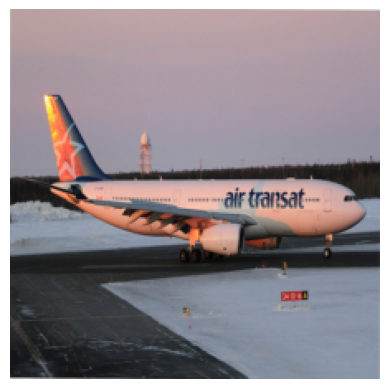

Generated Caption: a man of a a a a a a .


In [42]:
def test(model, tokenizer, max_length=20, device='cuda:0'):

     """
    Tests the model's ability to generate captions for a given image.

    Parameters:
    - model (nn.Module): Trained image captioning model.
    - tokenizer (Tokenizer): Tokenizer to decode predicted captions.
    - max_length (int): Maximum length of the generated caption.
    - device (str): Device (CPU or GPU) for computation.

    Procedure:
    - Preprocesses and displays the test image.
    - Generates a caption with the most probable word using the trained model.
    - Prints the generated caption.
    """
    
    model.eval()  

    img_display = resize_transform(test_img['jpg'])
    img = img_display.unsqueeze(0).to(device)

    plt.imshow(img_display.permute(1, 2, 0))  
    plt.axis('off')  
    plt.show() 
    
    caption = generate_caption(model, img, tokenizer, max_length, device)
            
    print(f"Generated Caption: {caption}")

def generate_caption(model, image_tensor, tokenizer, max_length=20, device='cuda:0'):

     """
    Generates a caption for a given image tensor using the trained model.

    Parameters:
    - model (nn.Module): Trained image captioning model.
    - image_tensor (torch.Tensor): Preprocessed image tensor of shape (1, C, H, W).
    - tokenizer (Tokenizer): Tokenizer to decode predicted captions.
    - max_length (int): Maximum length of the generated caption.
    - device (str): Device (CPU or GPU) for computation.

    Returns:
    - str: Generated caption as a string.

    """
    
    model.eval()
    
    with torch.no_grad():
        features = model.cnn_model(image_tensor).unsqueeze(1)  # Shape: (1, 1, cnn_output_size)
    
    start_token = tokenizer.cls_token_id
    input_ids = torch.tensor([[start_token]], device=device)  # Initial input with <start> token
    
    caption = [tokenizer.cls_token]  # Start with <start> token
    
    for _ in range(max_length):
        # Get embedding of the current captions
        embeddings = model.embedding(input_ids)  # Shape: (1, seq_length, embed_size)
        
        # Repeat CNN features to match current sequence length
        features_repeated = features.repeat(1, input_ids.size(1), 1)  # Shape: (1, seq_length, cnn_output_size)
        
        # Concatenate CNN features with the embeddings
        lstm_input = torch.cat((features_repeated, embeddings), dim=2)  # Shape: (1, seq_length, cnn_output_size + embed_size)
        
        # Pass features and input ids through LSTM
        outputs = model.lstm(lstm_input, None)[0]
        outputs = model.fc(outputs[:, -1, :])  
        #print(outputs.shape)
        
        # Get the predicted word (id) from the output
        predicted_id = torch.argmax(outputs, dim=-1).item()
        
        # Decode the predicted word and check if it is the end token
        predicted_word = tokenizer.decode([predicted_id])
        if predicted_word == tokenizer.sep_token:
            break
        
        caption.append(predicted_word)
        
        input_ids = torch.cat([input_ids, torch.tensor([[predicted_id]], device=device)], dim=1)
    
    return ' '.join(caption[1:])  
test(model, tokenizer, max_length=10, device=device)


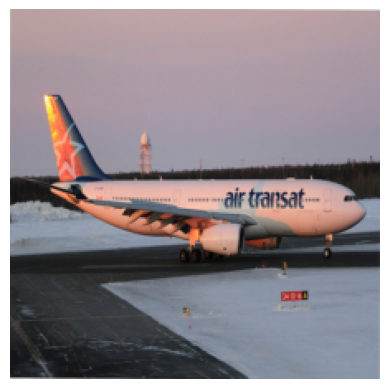

Generated Caption: a group and a on a the of a a


In [45]:
def test(model, tokenizer, max_length=20, device='cuda:1'):

    """
    Tests the model's ability to generate captions using top-k sampling.

    Parameters:
    - model (nn.Module): Trained image captioning model.
    - tokenizer (Tokenizer): Tokenizer to decode predicted captions.
    - max_length (int): Maximum length of the generated caption.
    - device (str): Device (CPU or GPU) for computation.

    Procedure:
    - Preprocess and display the test image.
    - Generates a caption using the trained model with top-k sampling (5 is the default).
    - Prints the generated caption.
    """
    
    model.eval()  

    img_display = resize_transform(test_img['jpg'])
    img = img_display.unsqueeze(0).to(device)

    plt.imshow(img_display.permute(1, 2, 0))  
    plt.axis('off')  
    plt.show() 
    
    caption = generate_caption(model, img, tokenizer, max_length, k=5, device=device)
            
    print(f"Generated Caption: {caption}")

def generate_caption(model, image_tensor, tokenizer, max_length=20, k=5, device='cuda:1'):

    """
    Generates a caption for a given image tensor using top-k sampling.

    Parameters:
    - model (nn.Module): Trained image captioning model.
    - image_tensor (torch.Tensor): Preprocessed image tensor of shape (1, C, H, W).
    - tokenizer (Tokenizer): Tokenizer to decode predicted captions.
    - max_length (int): Maximum length of the generated caption.
    - k (int): Number of top tokens to consider for sampling at each step.
    - device (str): Device (CPU or GPU) for computation.

    Returns:
    - str: Generated caption as a string.

    """
    
    model.eval()
    
    with torch.no_grad():
        features = model.cnn_model(image_tensor).unsqueeze(1)  # Shape: (1, 1, cnn_output_size)
    
    start_token = tokenizer.cls_token_id
    input_ids = torch.tensor([[start_token]], device=device)  # Initial input with <start> token
    
    caption = [tokenizer.cls_token]  
    
    for _ in range(max_length):
        # Get embedding of the current captions
        embeddings = model.embedding(input_ids)  # Shape: (1, seq_length, embed_size)
        
        # Repeat CNN features to match current sequence length
        features_repeated = features.repeat(1, input_ids.size(1), 1)  # Shape: (1, seq_length, cnn_output_size)
        
        # Concatenate CNN features with the embeddings
        lstm_input = torch.cat((features_repeated, embeddings), dim=2)  # Shape: (1, seq_length, cnn_output_size + embed_size)
        
        # Pass features and input ids through LSTM
        outputs = model.lstm(lstm_input, None)[0]
        outputs = model.fc(outputs[:, -1, :])  # Shape: (1, vocab_size)
        
        probs = F.softmax(outputs, dim=-1)  # Shape: (1, vocab_size)
        
        # Get the top-k token probabilities and their indices
        top_k_probs, top_k_indices = torch.topk(probs, k=k, dim=-1)
        
        top_k_probs = top_k_probs.squeeze().detach().cpu().numpy()
        top_k_indices = top_k_indices.squeeze().detach().cpu().numpy()
        
        # Pick one of the top-k based on probabilities
        predicted_id = np.random.choice(top_k_indices, p=top_k_probs/top_k_probs.sum())
        
        # Decode the predicted word and check if it is the end token
        predicted_word = tokenizer.decode([predicted_id])
        if predicted_word == tokenizer.sep_token:
            break
        
        caption.append(predicted_word)
        
        input_ids = torch.cat([input_ids, torch.tensor([[predicted_id]], device=device)], dim=1)
    
    return ' '.join(caption[1:])  

test(model, tokenizer, max_length=12, device=device)


In [3]:
test_img = vizwiz['train'][1000]['image']